In [68]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [69]:
import math
from dataclasses import dataclass

import torch
from botorch.acquisition import qExpectedImprovement
from botorch.fit import fit_gpytorch_model
from botorch.generation import MaxPosteriorSampling
from botorch.models import FixedNoiseGP, SingleTaskGP
from botorch.optim import optimize_acqf
from botorch.test_functions import Ackley
from botorch.utils.transforms import unnormalize
from torch.quasirandom import SobolEngine

import gpytorch
from gpytorch.constraints import Interval
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.mlls import ExactMarginalLogLikelihood
from gpytorch.priors import HorseshoePrior

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.float

In [59]:
fun = Ackley(dim=2, negate=True).to(dtype=dtype, device=device)
fun.bounds[0, :].fill_(-10)
fun.bounds[1, :].fill_(15)
dim = fun.dim
lb, ub = fun.bounds


def eval_objective(x):
    """This is a helper function we use to unnormalize and evalaute a point"""
    return fun(unnormalize(x, fun.bounds))

In [60]:
@dataclass
class TurboState:
    dim: int
    batch_size: int
    length: float = 0.8
    length_min: float = 0.5 ** 7
    length_max: float = 1.6
    failure_counter: int = 0
    failure_tolerance: int = float("nan")  # Note: Post-initialized
    success_counter: int = 0
    success_tolerance: int = 10  # Note: The original paper uses 3
    best_value: float = -float("inf")
    restart_triggered: bool = False

    def __post_init__(self):
        self.failure_tolerance = math.ceil(
            max([4.0 / self.batch_size, float(self.dim) / self.batch_size])
        )


def update_state(state, Y_next):
    if max(Y_next) > state.best_value + 1e-3 * math.fabs(state.best_value):
        state.success_counter += 1
        state.failure_counter = 0
    else:
        state.success_counter = 0
        state.failure_counter += 1

    if state.success_counter == state.success_tolerance:  # Expand trust region
        state.length = min(2.0 * state.length, state.length_max)
        state.success_counter = 0
    elif state.failure_counter == state.failure_tolerance:  # Shrink trust region
        state.length /= 2.0
        state.failure_counter = 0

    state.best_value = max(state.best_value, max(Y_next).item())
    if state.length < state.length_min:
        state.restart_triggered = True
    return state

In [61]:
state = TurboState(dim=dim, batch_size=4)
print(state)

TurboState(dim=2, batch_size=4, length=0.8, length_min=0.0078125, length_max=1.6, failure_counter=0, failure_tolerance=1, success_counter=0, success_tolerance=10, best_value=-inf, restart_triggered=False)


In [62]:
def get_initial_points(dim, n_pts):
    sobol = SobolEngine(dimension=dim, scramble=True)
    X_init = sobol.draw(n=n_pts).to(dtype=dtype, device=device)
    return X_init

Read comments in the next cell !!

In [64]:
def generate_batch(
    state,
    model,  # GP model
    X,  # Evaluated points on the domain [0, 1]^d
    Y,  # Function values
    batch_size,
    n_candidates=None,  # Number of candidates for Thompson sampling
    num_restarts=10,
    raw_samples=512,
    acqf="ts",  # "ei" or "ts"
):
    assert acqf in ("ts", "ei")
    assert X.min() >= 0.0 and X.max() <= 1.0 and torch.all(torch.isfinite(Y))
    if n_candidates is None:
        n_candidates = min(5000, max(2000, 200 * X.shape[-1]))

    # Scale the TR to be proportional to the lengthscales
    x_center = X[Y.argmax(), :].clone()
    # IMPORTANT, in TuRBO, the weights are defined by the lengthscale of the GP kernel
    # WHEN using EP, we don't have such a thing,
    # COMMENT/UNCOMMENT the following two lines accordingly
    # weights = model.covar_module.base_kernel.lengthscale.squeeze().detach()
    weights = torch.ones(2)
    
    weights = weights / weights.mean()
    weights = weights / torch.prod(weights.pow(1.0 / len(weights)))
    tr_lb = torch.clamp(x_center - weights * state.length / 2.0, 0.0, 1.0)
    tr_ub = torch.clamp(x_center + weights * state.length / 2.0, 0.0, 1.0)

    if acqf == "ts":
        dim = X.shape[-1]
        sobol = SobolEngine(dim, scramble=True)
        pert = sobol.draw(n_candidates).to(dtype=dtype, device=device)
        pert = tr_lb + (tr_ub - tr_lb) * pert

        # Create a perturbation mask
        prob_perturb = min(20.0 / dim, 1.0)
        mask = (
            torch.rand(n_candidates, dim, dtype=dtype, device=device)
            <= prob_perturb
        )
        ind = torch.where(mask.sum(dim=1) == 0)[0]
        mask[ind, torch.randint(0, dim - 1, size=(len(ind),), device=device)] = 1

        # Create candidate points from the perturbations and the mask        
        X_cand = x_center.expand(n_candidates, dim).clone()
        X_cand[mask] = pert[mask]

        # Sample on the candidate points
        thompson_sampling = MaxPosteriorSampling(model=model, replacement=False)
        X_next = thompson_sampling(X_cand, num_samples=batch_size)

    elif acqf == "ei":
        ei = qExpectedImprovement(model, train_Y.max(), maximize=True)
        X_next, acq_value = optimize_acqf(
            ei,
            bounds=torch.stack([tr_lb, tr_ub]),
            q=batch_size,
            num_restarts=num_restarts,
            raw_samples=raw_samples,
        )

    return X_next

In [65]:
batch_size = 4
n_init = 20  # 2*dim, which corresponds to 5 batches of 4

In [66]:
X_turbo = get_initial_points(dim, n_init)
Y_turbo = torch.tensor(
    [eval_objective(x) for x in X_turbo], dtype=dtype, device=device
).unsqueeze(-1)

state = TurboState(dim, batch_size=batch_size)

while not state.restart_triggered:  # Run until TuRBO converges
    # Fit a GP model
    train_Y = (Y_turbo - Y_turbo.mean()) / Y_turbo.std()
    likelihood = GaussianLikelihood(noise_constraint=Interval(1e-8, 1e-3))
    model = SingleTaskGP(X_turbo, train_Y, likelihood=likelihood)
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    fit_gpytorch_model(mll)
    
    # Create a batch
    X_next = generate_batch(
        state=state,
        model=model,
        X=X_turbo,
        Y=train_Y,
        batch_size=batch_size,
        n_candidates=min(5000, max(2000, 200 * dim)),
        num_restarts=10,
        raw_samples=512,
        acqf="ts",
    )
    Y_next = torch.tensor(
        [eval_objective(x) for x in X_next], dtype=dtype, device=device
    ).unsqueeze(-1)

    # Update state
    state = update_state(state=state, Y_next=Y_next)

    # Append data
    X_turbo = torch.cat((X_turbo, X_next), dim=0)
    Y_turbo = torch.cat((Y_turbo, Y_next), dim=0)

    # Print current status
    print(
        f"{len(X_turbo)}) Best value: {state.best_value:.2e}, TR length: {state.length:.2e}"
    )

/Users/salem/miniconda3/envs/epistemic/lib/python3.8/site-packages/gpytorch/utils/cholesky.py:46: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


24) Best value: -1.79e+00, TR length: 4.00e-01


/Users/salem/miniconda3/envs/epistemic/lib/python3.8/site-packages/gpytorch/utils/cholesky.py:46: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


28) Best value: -1.64e+00, TR length: 4.00e-01


/Users/salem/miniconda3/envs/epistemic/lib/python3.8/site-packages/gpytorch/utils/cholesky.py:46: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


32) Best value: -7.03e-01, TR length: 4.00e-01


/Users/salem/miniconda3/envs/epistemic/lib/python3.8/site-packages/gpytorch/utils/cholesky.py:46: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


36) Best value: -6.55e-01, TR length: 4.00e-01
40) Best value: -2.08e-01, TR length: 4.00e-01


/Users/salem/miniconda3/envs/epistemic/lib/python3.8/site-packages/gpytorch/lazy/lazy_tensor.py:1354: NumericalWarning: Runtime Error when computing Cholesky decomposition: Matrix not positive definite after repeatedly adding jitter up to 1.0e-04. Original error on first attempt: cholesky_cpu: U(1144,1144) is zero, singular U.. Using RootDecomposition.
  warnings.warn(


44) Best value: -2.08e-01, TR length: 2.00e-01


/Users/salem/miniconda3/envs/epistemic/lib/python3.8/site-packages/gpytorch/utils/cholesky.py:46: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


48) Best value: -1.45e-01, TR length: 2.00e-01


/Users/salem/miniconda3/envs/epistemic/lib/python3.8/site-packages/gpytorch/utils/cholesky.py:46: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


52) Best value: -1.45e-01, TR length: 1.00e-01


/Users/salem/miniconda3/envs/epistemic/lib/python3.8/site-packages/gpytorch/utils/cholesky.py:46: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


56) Best value: -1.45e-01, TR length: 5.00e-02


/Users/salem/miniconda3/envs/epistemic/lib/python3.8/site-packages/gpytorch/utils/cholesky.py:46: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


60) Best value: -7.97e-02, TR length: 5.00e-02


/Users/salem/miniconda3/envs/epistemic/lib/python3.8/site-packages/gpytorch/utils/cholesky.py:46: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


64) Best value: -3.35e-02, TR length: 5.00e-02


/Users/salem/miniconda3/envs/epistemic/lib/python3.8/site-packages/gpytorch/utils/cholesky.py:46: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


68) Best value: -3.35e-02, TR length: 2.50e-02


/Users/salem/miniconda3/envs/epistemic/lib/python3.8/site-packages/gpytorch/utils/cholesky.py:46: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


72) Best value: -3.01e-02, TR length: 2.50e-02


/Users/salem/miniconda3/envs/epistemic/lib/python3.8/site-packages/gpytorch/utils/cholesky.py:46: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


76) Best value: -1.73e-02, TR length: 2.50e-02


/Users/salem/miniconda3/envs/epistemic/lib/python3.8/site-packages/gpytorch/utils/cholesky.py:46: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


80) Best value: -1.73e-02, TR length: 1.25e-02


/Users/salem/miniconda3/envs/epistemic/lib/python3.8/site-packages/gpytorch/lazy/lazy_tensor.py:1354: NumericalWarning: Runtime Error when computing Cholesky decomposition: Matrix not positive definite after repeatedly adding jitter up to 1.0e-04. Original error on first attempt: cholesky_cpu: U(4,4) is zero, singular U.. Using RootDecomposition.
  warnings.warn(


84) Best value: -1.73e-02, TR length: 6.25e-03


In [16]:
X_Sobol = (SobolEngine(dim, scramble=True).draw(len(X_turbo)).to(dtype=dtype, device=device))
Y_Sobol = torch.tensor([eval_objective(x) for x in X_Sobol], dtype=dtype, device=device).unsqueeze(-1)

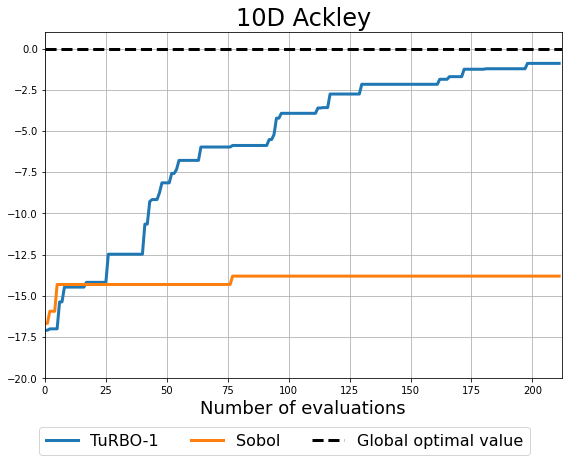

In [17]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import rc

%matplotlib inline


names = ["TuRBO-1", "Sobol"]
runs = [Y_turbo, Y_Sobol]
fig, ax = plt.subplots(figsize=(8, 6))

for name, run in zip(names, runs):
    fx = np.maximum.accumulate(run.cpu())
    plt.plot(fx, marker="", lw=3)

plt.plot([0, len(Y_turbo)], [fun.optimal_value, fun.optimal_value], "k--", lw=3)
plt.xlabel("Function value", fontsize=18)
plt.xlabel("Number of evaluations", fontsize=18)
plt.title("10D Ackley", fontsize=24)
plt.xlim([0, len(Y_turbo)])
plt.ylim([-20, 1])

plt.grid(True)
plt.tight_layout()
plt.legend(
    names + ["Global optimal value"],
    loc="lower center",
    bbox_to_anchor=(0, -0.08, 1, 1),
    bbox_transform=plt.gcf().transFigure,
    ncol=4,
    fontsize=16,
)
plt.show()

## TuRBO with EP as local model

In [67]:
from uncertaintylearning.utils import (FixedKernelDensityEstimator, CVKernelDensityEstimator,
                                       create_network, create_optimizer, create_multiplicative_scheduler)
from uncertaintylearning.models import EpistemicPredictor

X_turboEP = get_initial_points(dim, n_init)
Y_turboEP = torch.tensor(
    [eval_objective(x) for x in X_turboEP], dtype=dtype, device=device
).unsqueeze(-1)

ackley_dim = dim

networks = {'a_predictor': create_network(ackley_dim, 1, 64, 'tanh', True),
                'e_predictor': create_network(1 + ackley_dim, 1, 64, 'relu', True),
                'f_predictor': create_network(ackley_dim, 1, 64, 'relu', False)
                }

optimizers = {'a_optimizer': create_optimizer(networks['a_predictor'], 1e-3),
              'e_optimizer': create_optimizer(networks['e_predictor'], 1e-4),
              'f_optimizer': create_optimizer(networks['f_predictor'], 1e-3)
             }


density_estimator = FixedKernelDensityEstimator('exponential', 0.1)

epochs = 50

state = TurboState(dim, batch_size=batch_size)

while not state.restart_triggered:  # Run until TuRBO converges
    # Fit a GP model
    train_Y = (Y_turboEP - Y_turboEP.mean()) / Y_turboEP.std()
    
    if len(X_turbo) > 50:
        iid_ratio = 1
    
    model = EpistemicPredictor(X_turboEP, train_Y, train_Y_2=None, density_estimator=density_estimator,
                              iid_ratio=iid_ratio, networks=networks, optimizers=optimizers, batch_size=64,
                              bounds=(0, 1)
                              )
    
    for _ in range(epochs):
        losses = model.fit()
#     likelihood = GaussianLikelihood(noise_constraint=Interval(1e-8, 1e-3))
#     model = SingleTaskGP(X_turbo, train_Y, likelihood=likelihood)
#     mll = ExactMarginalLogLikelihood(model.likelihood, model)
#     fit_gpytorch_model(mll)
    
    # Create a batch
    X_next = generate_batch(
        state=state,
        model=model,
        X=X_turbo,
        Y=train_Y,
        batch_size=batch_size,
        n_candidates=min(5000, max(2000, 200 * dim)),
        num_restarts=10,
        raw_samples=512,
        acqf="ts",
    )
    Y_next = torch.tensor(
        [eval_objective(x) for x in X_next], dtype=dtype, device=device
    ).unsqueeze(-1)

    # Update state
    state = update_state(state=state, Y_next=Y_next)

    # Append data
    X_turboEP = torch.cat((X_turboEP, X_next), dim=0)
    Y_turboEP = torch.cat((Y_turboEP, Y_next), dim=0)

    # Print current status
    print(
        f"{len(X_turboEP)}) Best value: {state.best_value:.2e}, TR length: {state.length:.2e}"
    )

24) Best value: -1.72e+01, TR length: 4.00e-01
28) Best value: -1.72e+01, TR length: 2.00e-01
32) Best value: -1.72e+01, TR length: 1.00e-01
36) Best value: -1.72e+01, TR length: 5.00e-02
40) Best value: -1.72e+01, TR length: 2.50e-02
44) Best value: -1.72e+01, TR length: 1.25e-02
48) Best value: -1.72e+01, TR length: 6.25e-03
